<a href="https://colab.research.google.com/github/youhangkai/SHARING/blob/main/atm520.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
figure1 = geemap.Map()
figure1.add_basemap('OpenTopoMap')
cam = ee.Geometry.Polygon(
        [
              [
                [-77,7],
                [-77,20],
                [-100,20],
                [-100,7],
                [-77,7]
              ]
        ],
        None,
        False,
    )

figure1.addLayer(cam, {}, "Central America")
figure1.centerObject(cam,4)

figure1

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=qKQ8nvBs9fGUYmgVzmkEnk9py21mi1xblhfSiNTmwus&tc=mHEcZ53n4i2M0E8a2WvUAADLmeY6YEfW6J9iFhefKkk&cc=IETEKe_Efh7t7JbLitEXY-5TyQHVsEw141aU_ZrBfkk

The authorization workflow will generate a code, which you should paste in the box below.


KeyboardInterrupt: ignored

In [ ]:
!pip install netCDF4 numpy
!pip install goes16ci
!pip install pyproj
!pip install cartopy
import netCDF4 as nc
from google.cloud import storage
import netCDF4 as nc
import numpy as np
from pyproj import Proj, transform
import xarray as xr
import matplotlib.pyplot as plt
from PIL import Image
import imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 81.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 262.9 kB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp310-linux_x86_64.whl size=11102741 sha256=2753b47fd0bf153cacb50a5484bdd5bb9be7c93878b6cb5b331cb2aa3d0cf3fd
  Stored in directory: /root/.cache/pip/wheels/30/b0/1a/1c1909e00c76653dc4e2ff48555257c0eb2d1698280c8d9955
Successfully built cartopy


1


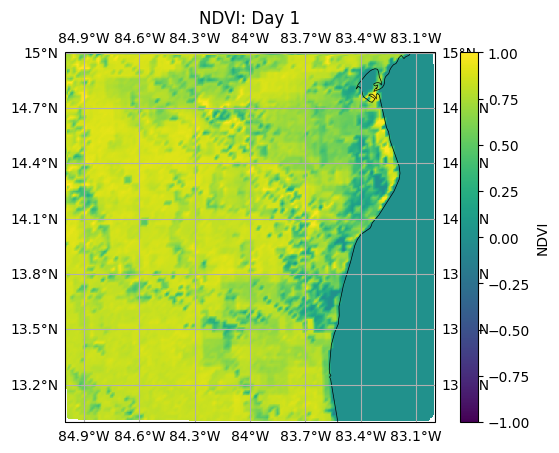

2


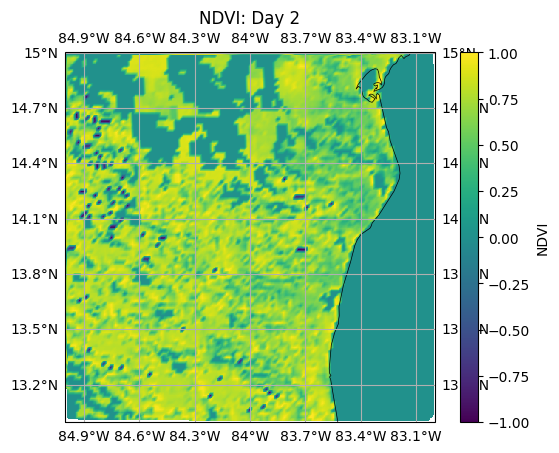

3


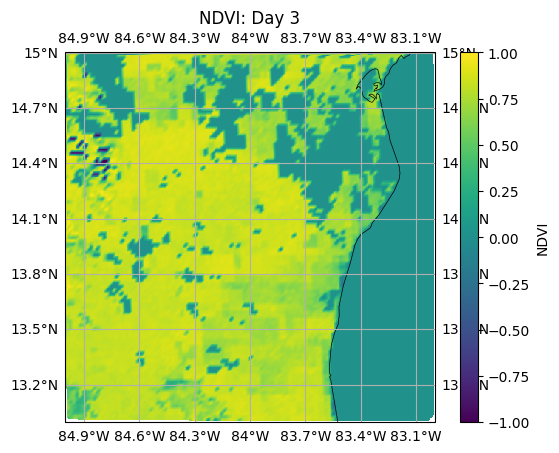

5


KeyboardInterrupt: ignored

In [ ]:
import numpy as np
import netCDF4 as nc
from google.cloud import storage
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
from scipy.interpolate import griddata

# Fetch and process data function
def fetch_and_process_data(day):
    R = {}
    NIR = {}
    NDVI = {}
    sat = '16'
    product = 'ABI-L2-BRFF'
    year = '2022'
    hour = '18'
    storage_client = storage.Client.create_anonymous_client()

    day_str = str(day).zfill(3)

    bucket_name = f'gcp-public-data-goes-{sat}'
    prefix = f'{product}/{year}/{day}/{hour}'
    blob_list = list(storage_client.list_blobs(bucket_name, prefix=prefix))

    file = blob_list[0]
    file_name = file.name.replace("/", "_")
    out_file = f'/content/{file_name}'
    each_blob = storage.Blob(file.name, storage_client.get_bucket(bucket_name))
    ds = each_blob.download_to_filename(out_file)

    dataset = nc.Dataset(out_file)

    R_full = dataset.variables['BRF2'][:]
    NIR_full = dataset.variables['BRF3'][:]

    abi_lat, abi_lon = calculate_degrees(dataset)

    # Choose part of the Central America region
    lat_min, lat_max = 13, 15
    lon_min, lon_max = -85, -83

    mask = (abi_lat >= lat_min) & (abi_lat <= lat_max) & (abi_lon >= lon_min) & (abi_lon <= lon_max)

    R_full = np.where(mask, R_full, np.nan)
    NIR_full = np.where(mask, NIR_full, np.nan)

    R[day_str] = R_full
    NIR[day_str] = NIR_full

    NDVI[day_str] = (NIR[day_str] - R[day_str]) / (R[day_str] + NIR[day_str])
    dataset.close()

    return NDVI[day_str], abi_lat, abi_lon, mask

# Calculate degrees function
def calculate_degrees(file_id):
    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = file_id.variables['x'][:]
    y_coordinate_1d = file_id.variables['y'][:]
    projection_info = file_id.variables['goes_imager_projection']
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height + projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis

    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)

    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin * np.pi) / 180.0
    a_var = np.power(np.sin(x_coordinate_2d), 2.0) + (np.power(np.cos(x_coordinate_2d), 2.0) * (np.power(np.cos(y_coordinate_2d), 2.0) + (((r_eq * r_eq) / (r_pol * r_pol)) * np.power(np.sin(y_coordinate_2d), 2.0))))
    b_var = -2.0 * H * np.cos(x_coordinate_2d) * np.cos(y_coordinate_2d)
    c_var = (H**2.0) - (r_eq**2.0)
    r_s = (-1.0 * b_var - np.sqrt((b_var**2) - (4.0 * a_var * c_var))) / (2.0 * a_var)
    s_x = r_s * np.cos(x_coordinate_2d) * np.cos(y_coordinate_2d)
    s_y = - r_s * np.sin(x_coordinate_2d)
    s_z = r_s * np.cos(x_coordinate_2d) * np.sin(y_coordinate_2d)

    # Ignore numpy errors for sqrt of negative number; occurs for GOES-16 ABI CONUS sector data
    np.seterr(all='ignore')

    abi_lat = (180.0 / np.pi) * (np.arctan(((r_eq * r_eq) / (r_pol * r_pol)) * ((s_z / np.sqrt(((H - s_x) * (H - s_x)) + (s_y * s_y))))))
    abi_lon = (lambda_0 - np.arctan(s_y / (H - s_x))) * (180.0 / np.pi)

    return abi_lat, abi_lon

# Set the start and end days (from 1 to 365)
start_day = 1
end_day = 365

# Days to skip
skip_days = [4, 64, 77, 139, 144, 241, 256, 321, 335]

# Choose the Central America region
lat_min, lat_max = 13, 15
lon_min, lon_max = -85, -83

# Define the latitude-longitude grid
lon_grid, lat_grid = np.meshgrid(np.linspace(lon_min, lon_max, 500), np.linspace(lat_min, lat_max, 500))

# Initialize an empty dictionary to store NDVI data for each day
NDVI_dict = {}

for day in range(start_day, end_day + 1):
    if day in skip_days:
        continue
    print(day)
    day_str = str(day).zfill(3)
    NDVI_day, abi_lat, abi_lon, mask = fetch_and_process_data(day_str)

    # Interpolate NDVI values onto the latitude-longitude grid
    NDVI_interp = griddata((abi_lon[mask], abi_lat[mask]), NDVI_day[mask], (lon_grid, lat_grid), method='linear')

    # Plot the NDVI image on a map using cartopy
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    cmap = plt.get_cmap('viridis')
    norm = colors.Normalize(vmin=-1, vmax=1)

    cax = ax.pcolormesh(lon_grid, lat_grid, NDVI_interp, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    fig.colorbar(cax, ax=ax, label="NDVI")
    ax.set_title(f"NDVI: Day {day}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.coastlines(resolution='10m', color='black', linewidth=0.5)
    ax.gridlines(draw_labels=True)
    plt.show()

    NDVI_dict[day] = NDVI_interp

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get the dimensions of the lon_grid and lat_grid arrays
nlat, nlon = lon_grid.shape

# Initialize an empty 2D array to store the NDVI values for each day
NDVI_array = np.empty((valid_days, nlat * nlon))

# Loop through the NDVI dictionary and store the NDVI values in the NDVI_array
for i, (day, NDVI_interp) in enumerate(NDVI_dict.items()):
    NDVI_array[i, :] = NDVI_interp.flatten()

# Transpose the NDVI_array to have time on the x-axis and NDVI values on the y-axis
NDVI_array = NDVI_array.T

# Plot the heatmap using matplotlib
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.imshow(NDVI_array, cmap='viridis', aspect='auto', origin='lower', vmin=-1, vmax=1)
fig.colorbar(cax, ax=ax, label="NDVI")
ax.set_title("NDVI Heatmap")
ax.set_xlabel("Time (days)")
ax.set_ylabel("NDVI")
plt.show()


IndexError: ignored

In [ ]:
import numpy as np
import netCDF4 as nc
from google.cloud import storage
import matplotlib.pyplot as plt

def fetch_and_process_data(day):
    R = {}
    NIR = {}
    NDVI = {}
    sat = '16'
    product = 'ABI-L2-BRFF'
    year = '2022'
    hour = '18'
    storage_client = storage.Client.create_anonymous_client()

    day_str = str(day).zfill(3)

    bucket_name = f'gcp-public-data-goes-{sat}'
    prefix = f'{product}/{year}/{day}/{hour}'
    blob_list = list(storage_client.list_blobs(bucket_name, prefix=prefix))

    file = blob_list[0]
    file_name = file.name.replace("/", "_")
    out_file = f'/content/{file_name}'
    each_blob = storage.Blob(file.name, storage_client.get_bucket(bucket_name))
    ds = each_blob.download_to_filename(out_file)

    dataset = nc.Dataset(out_file)

    R_full = dataset.variables['BRF2'][:]
    NIR_full = dataset.variables['BRF3'][:]

    # Calculate the indices for slicing the arrays
    height, width = R_full.shape
    y_start, y_end = int(height * 0.3), int(height * 0.55)
    x_start, x_end = int(width * 0.3), int(width * 0.55)

    # Slice the arrays
    R[day_str] = R_full[y_start:y_end, x_start:x_end]
    NIR[day_str] = NIR_full[y_start:y_end, x_start:x_end]

    gamma = 1.5
    R[day_str] = np.power(R[day_str], 1/gamma)
    NIR[day_str] = np.power(NIR[day_str], 1/gamma)

    NDVI[day_str] = (NIR[day_str] - R[day_str]) / (R[day_str] + NIR[day_str])
    dataset.close()

    return NDVI[day_str]


start_day = 1
end_day = 366
NDVI = {}
NDVI_diff = {}
mean_ndvi = {}
for day in range(start_day, end_day):
  if day in [4, 64, 77, 139, 144, 241, 256, 321, 335]:
  # if day in [241, 256, 321, 335]:
        print('skipped', day)
        mean_ndvi[day] = np.nan
        continue
        # missing data here
  day_str = str(day).zfill(3)
  NDVI = fetch_and_process_data(day_str)
  mean_ndvi[day] = np.mean(NDVI)
  print(['finished '+str(day)])

['finished 1']
['finished 2']
['finished 3']
skipped 4
['finished 5']
['finished 6']
['finished 7']
['finished 8']
['finished 9']
['finished 10']
['finished 11']
['finished 12']
['finished 13']
['finished 14']
['finished 15']
['finished 16']
['finished 17']
['finished 18']
['finished 19']
['finished 20']
['finished 21']
['finished 22']
['finished 23']
['finished 24']
['finished 25']
['finished 26']
['finished 27']
['finished 28']
['finished 29']
['finished 30']
['finished 31']
['finished 32']
['finished 33']
['finished 34']
['finished 35']
['finished 36']
['finished 37']
['finished 38']
['finished 39']
['finished 40']
['finished 41']
['finished 42']
['finished 43']
['finished 44']
['finished 45']
['finished 46']
['finished 47']
['finished 48']
['finished 49']
['finished 50']
['finished 51']
['finished 52']
['finished 53']
['finished 54']
['finished 55']
['finished 56']
['finished 57']
['finished 58']
['finished 59']
['finished 60']
['finished 61']
['finished 62']
['finished 63']
skippe

In [ ]:
NDVI.shape

(1356, 1356)

In [ ]:
mean_ndvi

NameError: ignored

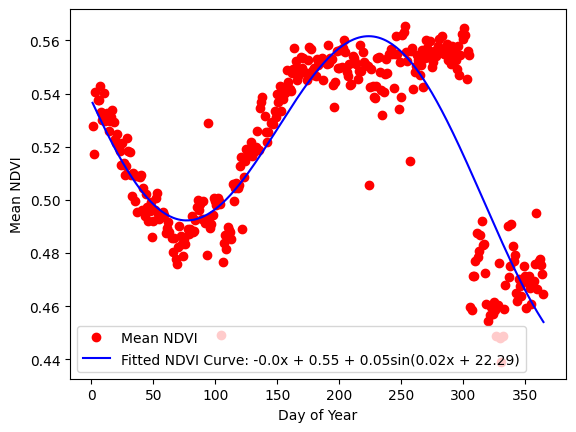

f(x) = -0.00016491307078603937 * x + 0.551728819660885 + 0.04757909370991294 * sin(0.018870513168321803 * x + 22.29417508254667)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define a function that combines a linear equation and a sine function
def linear_sine(x, a, b, c, d, e):
    return a * x + b + c * np.sin(d * x + e)

# Create a list of days to exclude
exclude_days = [4, 64, 77, 139, 144, 241, 256, 321, 335]
start_day = 1
end_day = 366

my_array = np.array(list(mean_ndvi.values()))
mean_ndvi_values = my_array
# Create a new list that includes only the non-NaN values
mean_ndvi_values = mean_ndvi_values[~np.isnan(mean_ndvi_values)]

array = [range(1,4),range(5,64),range(65,77),range(78,139),range(140,144),range(145,241),range(242,256),range(257,321),range(322,335),range(336,366)]
# array = [range(230,241),range(242,256),range(257,321),range(322,335),range(336,366)]

# Concatenate all ranges into a single array
x = np.concatenate(array)


# Fit the linear sine function to the non-NaN values
popt, pcov = curve_fit(linear_sine, x, mean_ndvi_values, p0=[0,0.001,0.00001,0.000001,0.01])

# Plot the original mean NDVI data and the fitted linear sine curve
plt.plot(x, mean_ndvi_values, 'ro', label='Mean NDVI')
plt.plot(x, linear_sine(x, *popt), 'b-', label='Fitted NDVI Curve: {}x + {} + {}sin({}x + {})'.format(round(popt[0],2), round(popt[1],2), round(popt[2],2), round(popt[3],2), round(popt[4],2)))
plt.xlabel('Day of Year')
plt.ylabel('Mean NDVI')
plt.legend()
plt.show()
print("f(x) = {} * x + {} + {} * sin({} * x + {})".format(*popt))


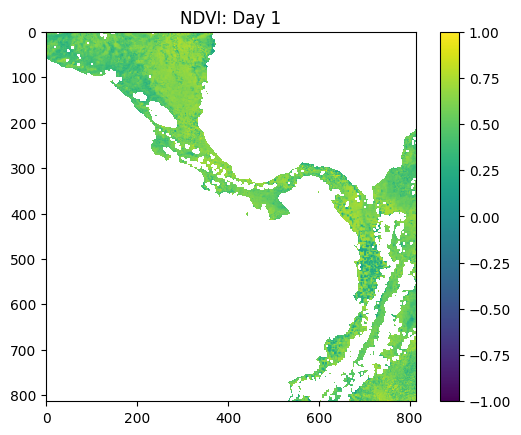

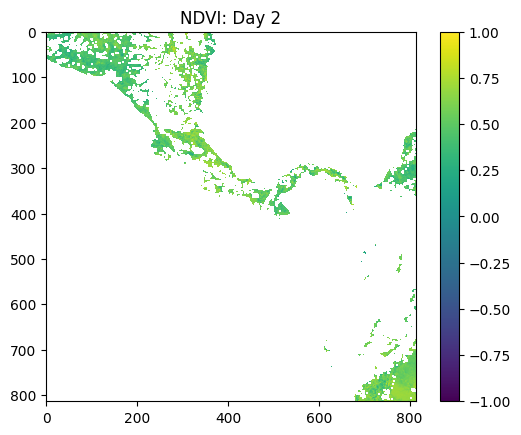

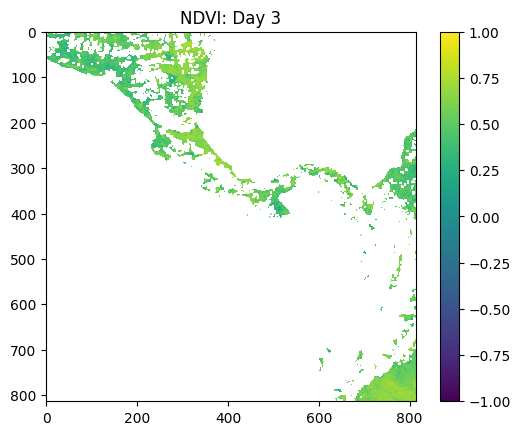

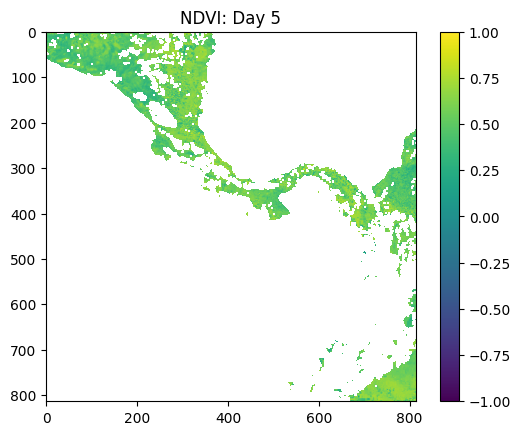

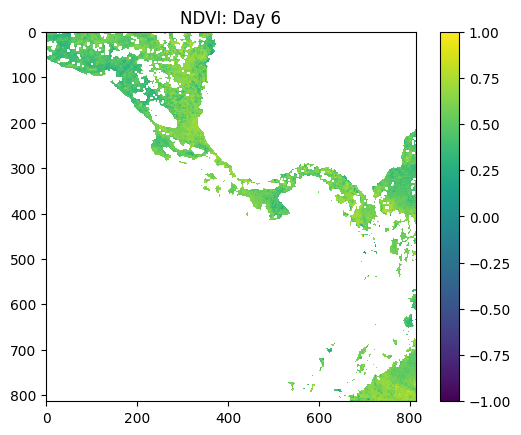

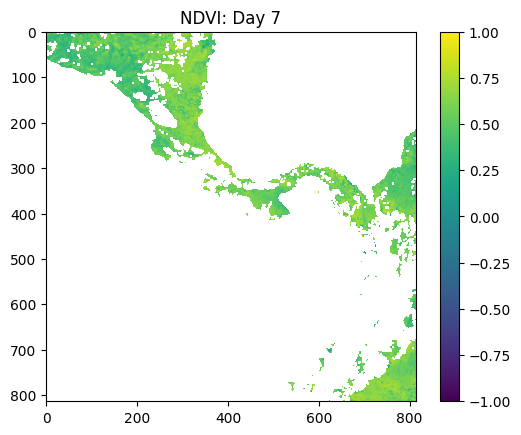

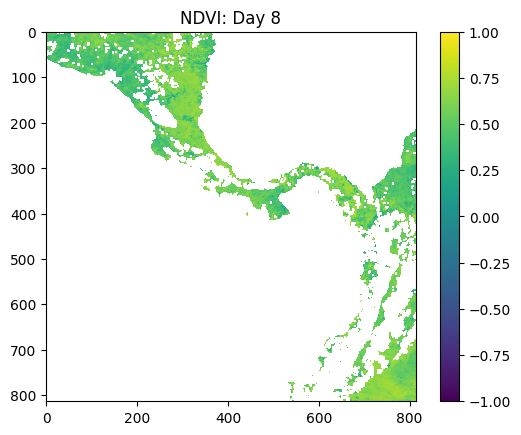

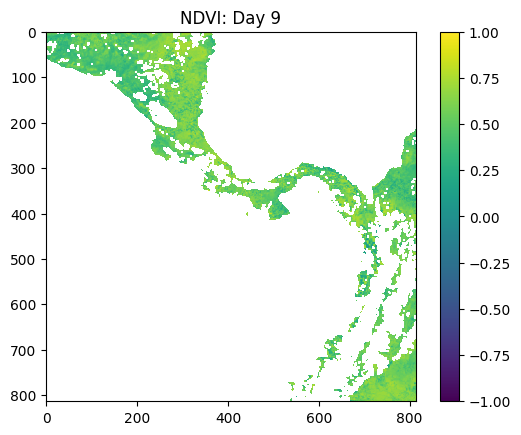

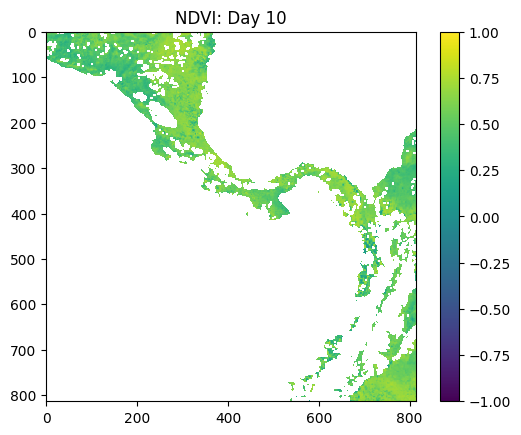

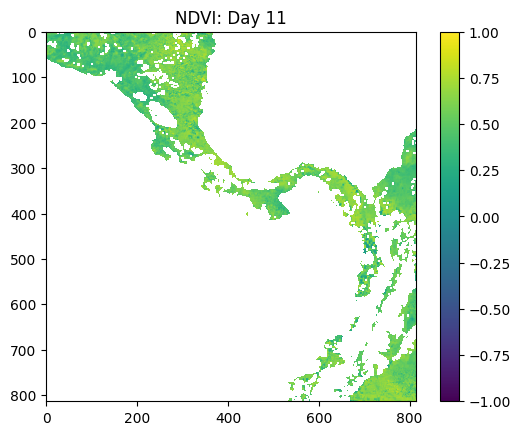

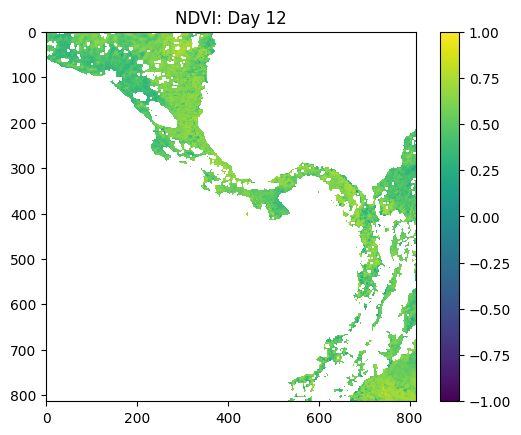

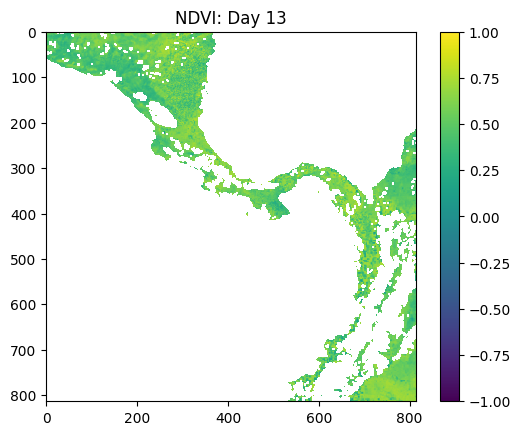

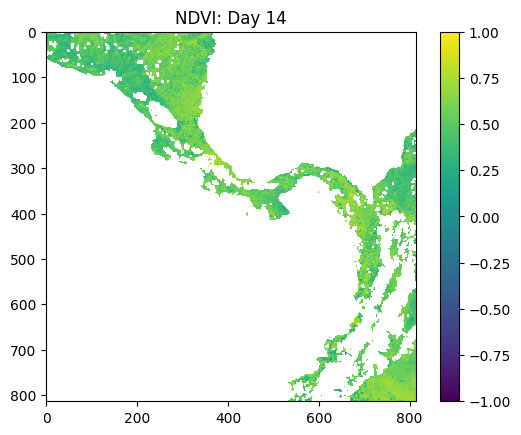

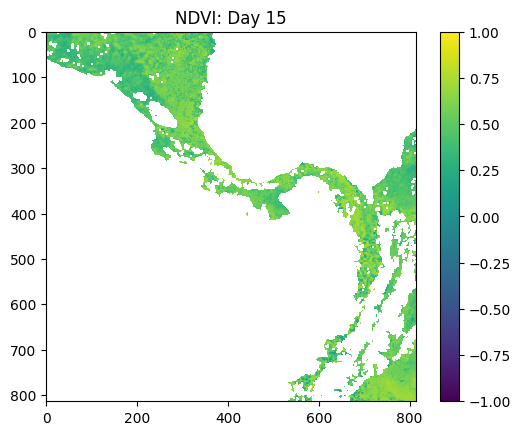

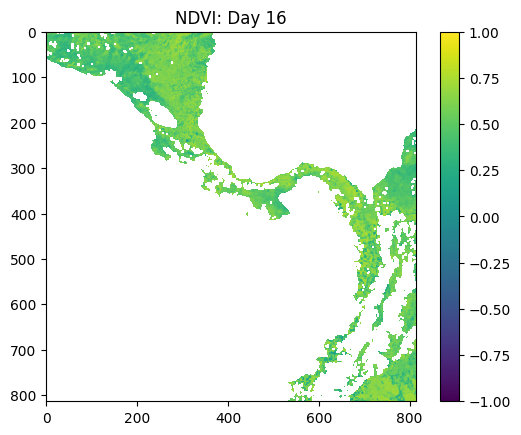

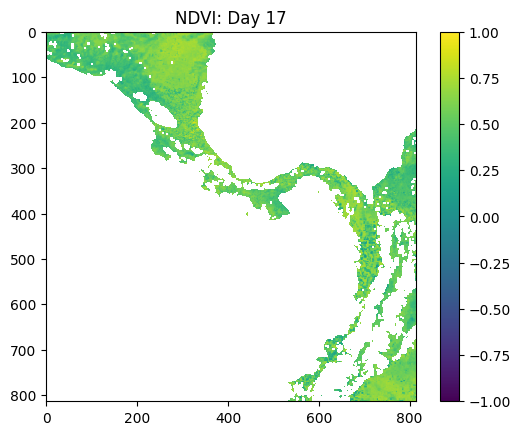

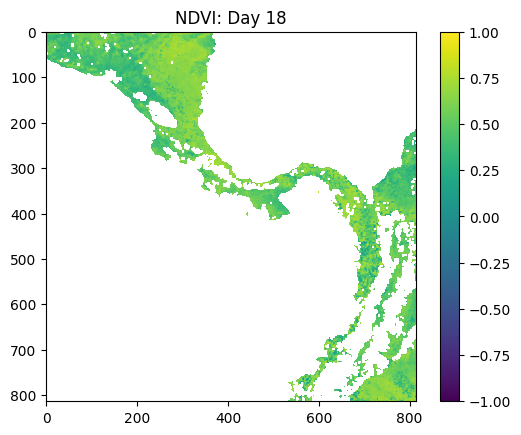

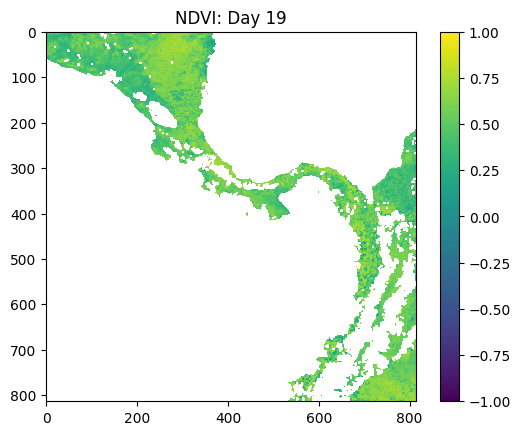

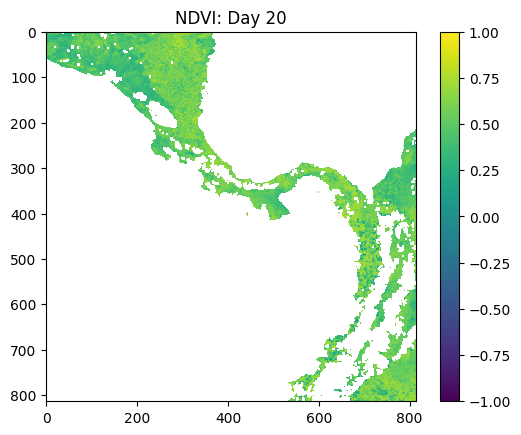

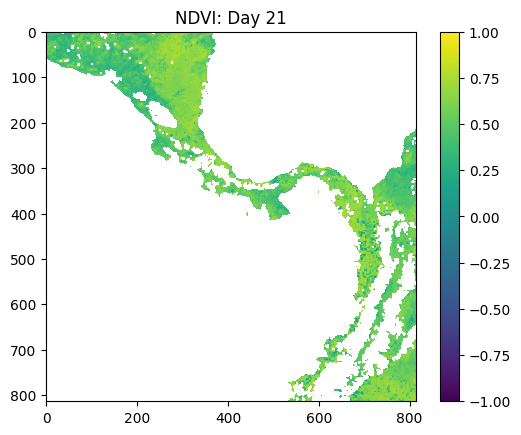

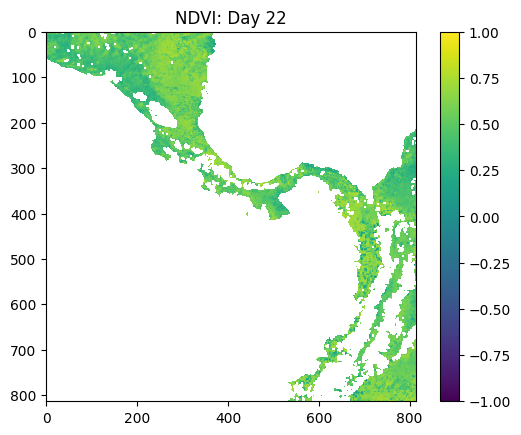

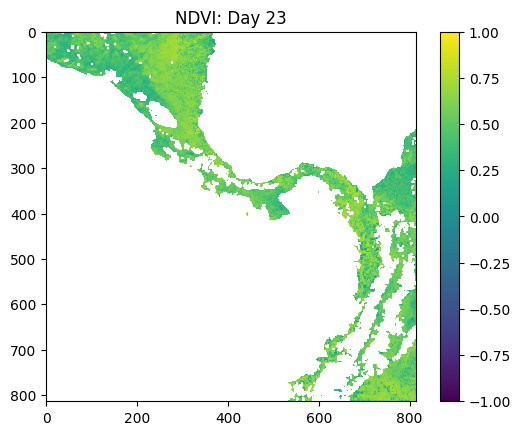

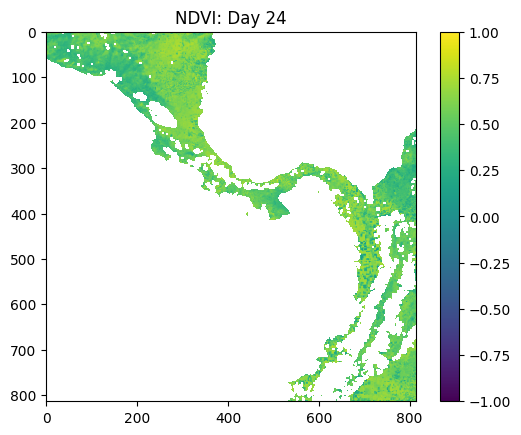

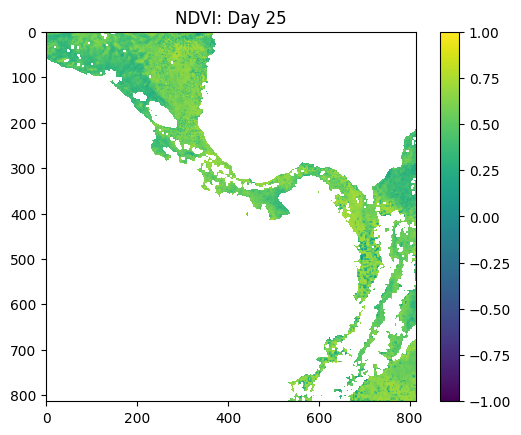

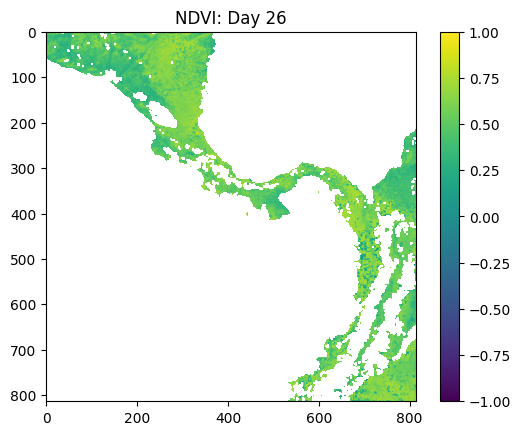

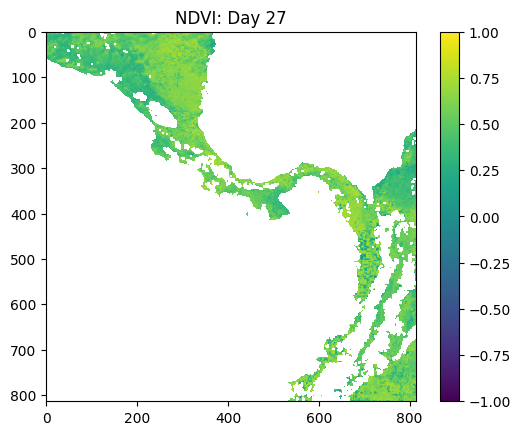

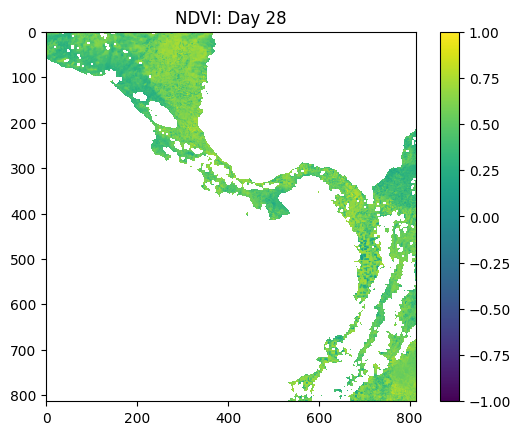

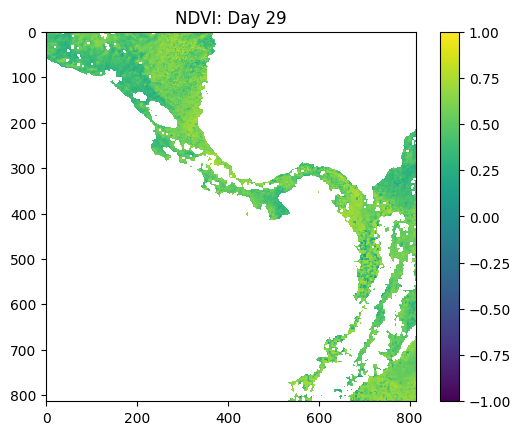

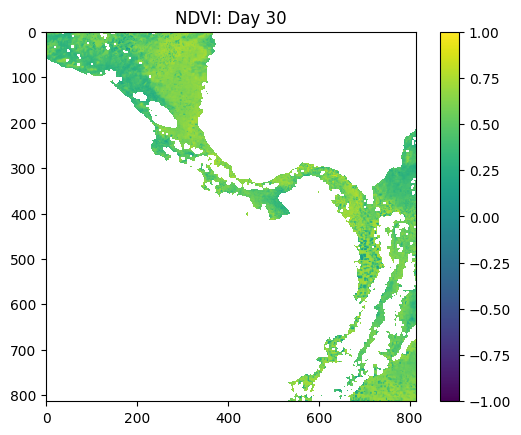

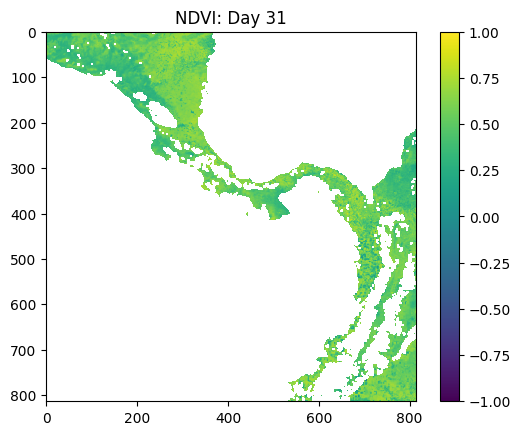

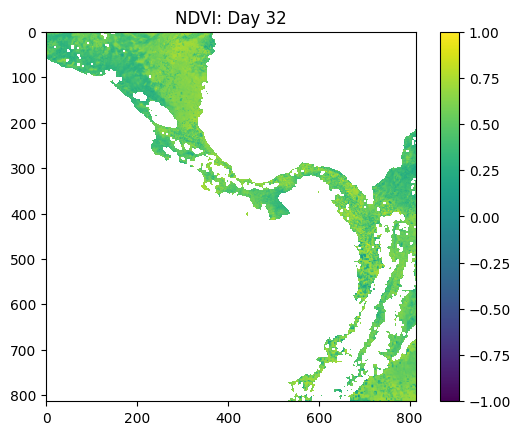

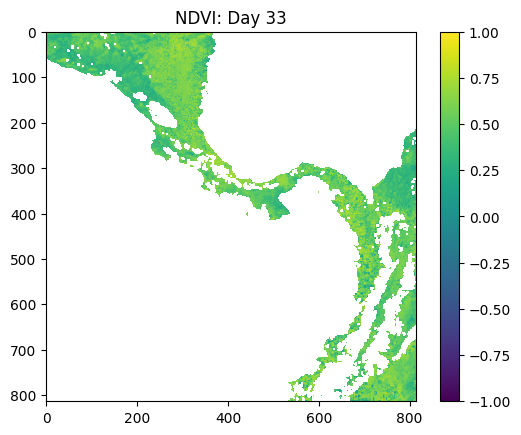

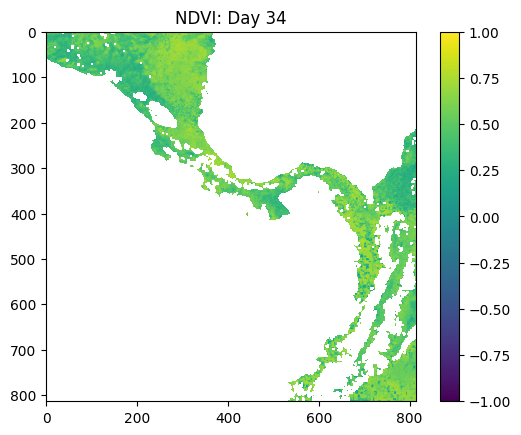

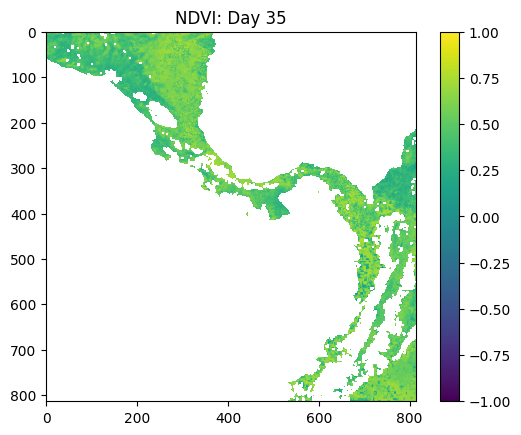

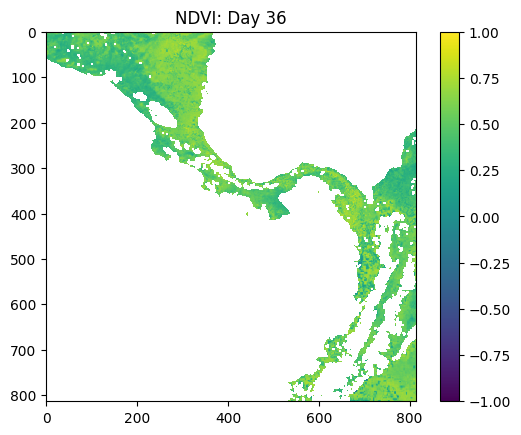

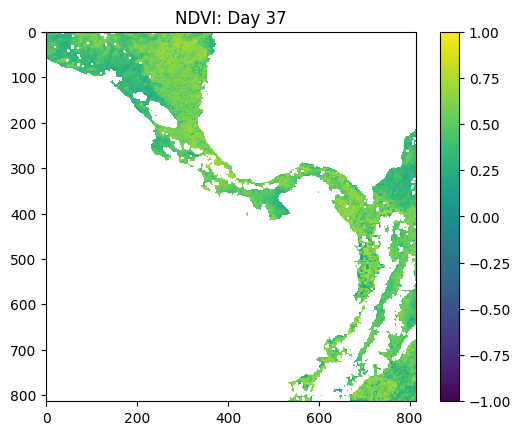

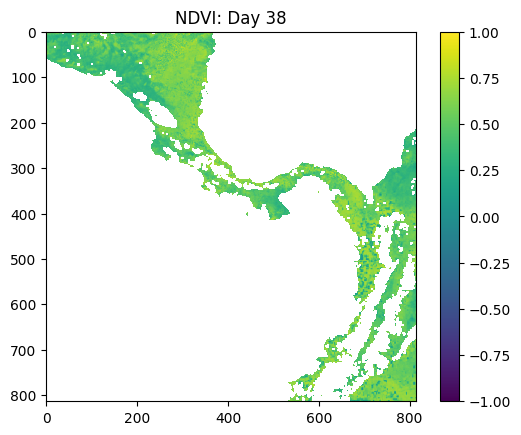

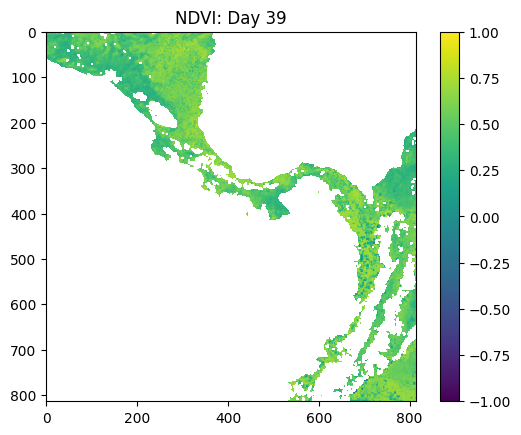

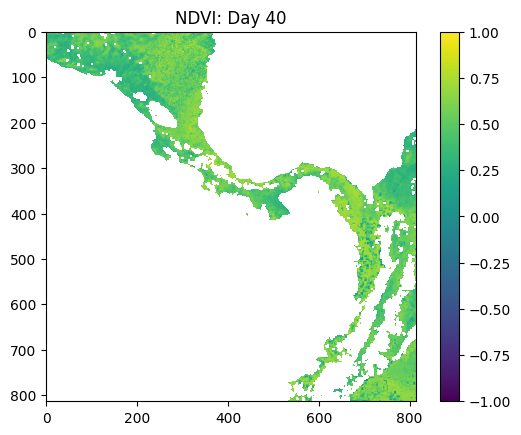

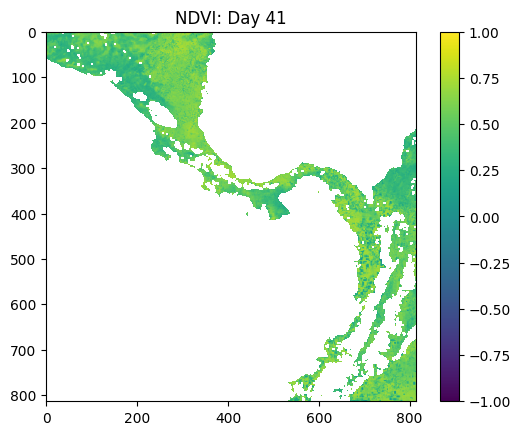

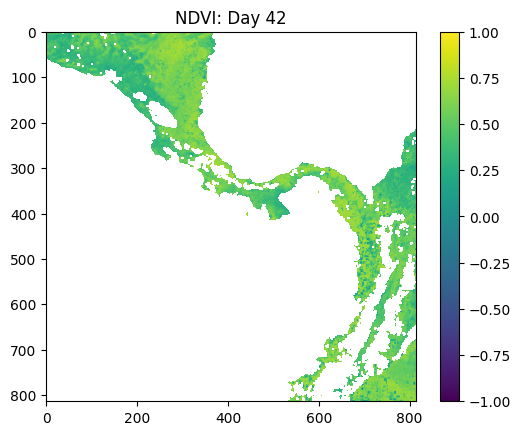

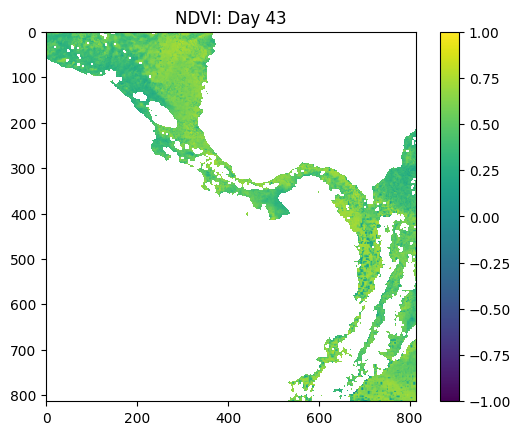

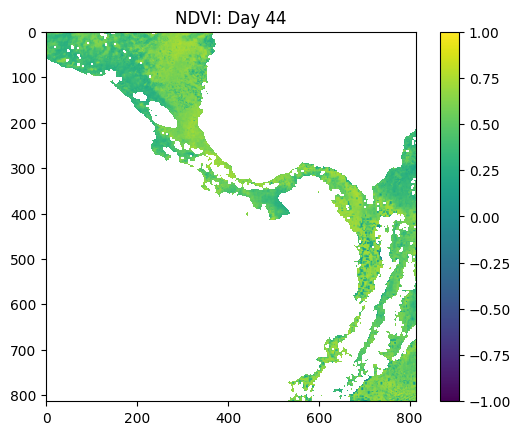

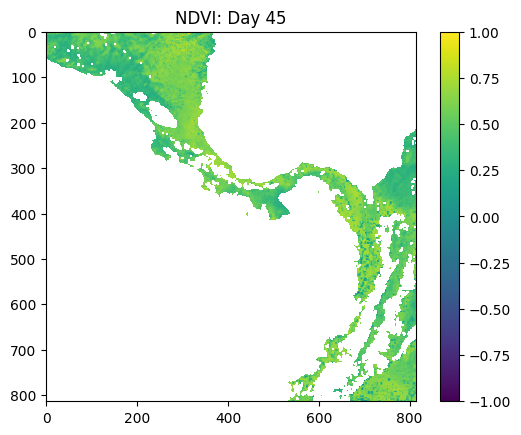

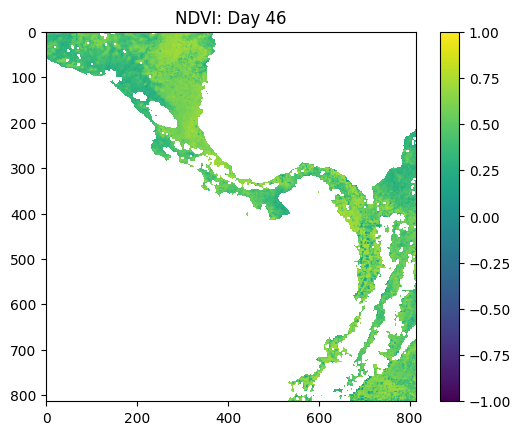

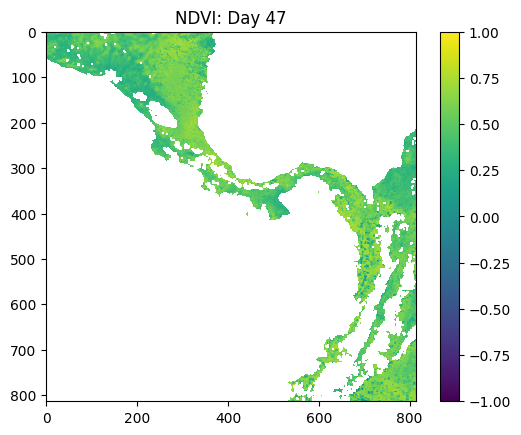

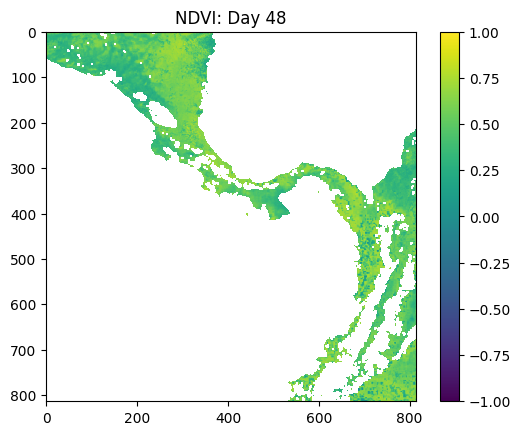

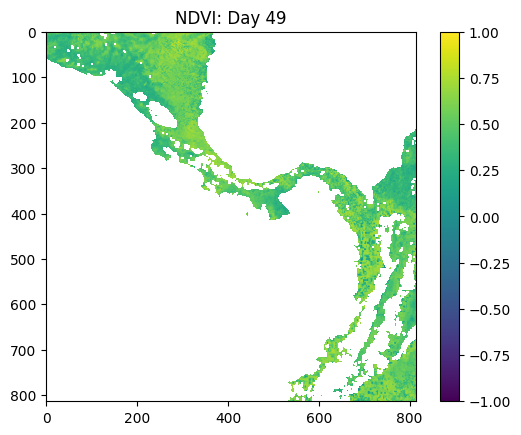

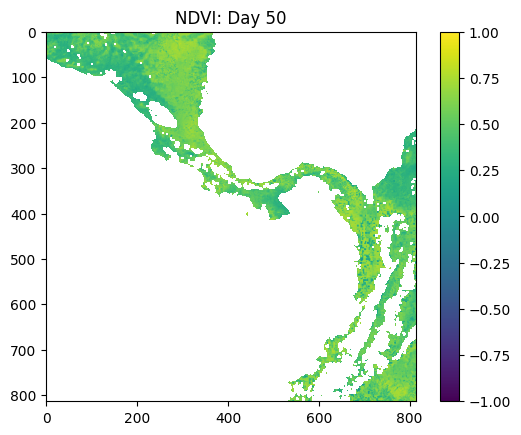

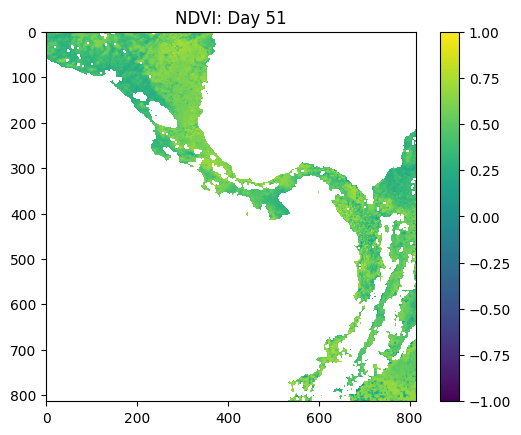

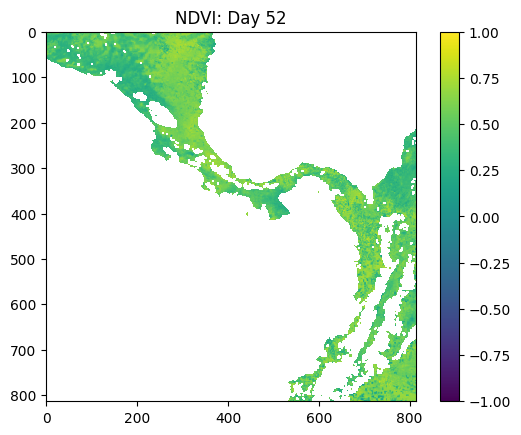

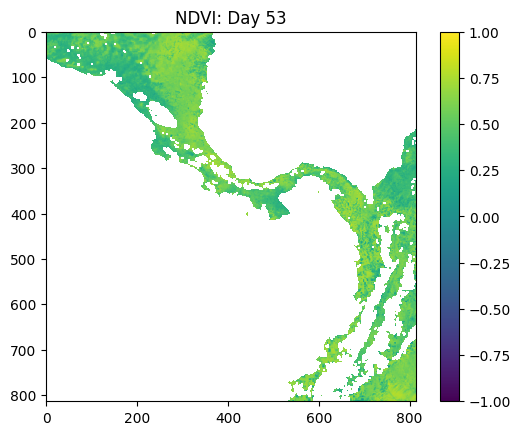

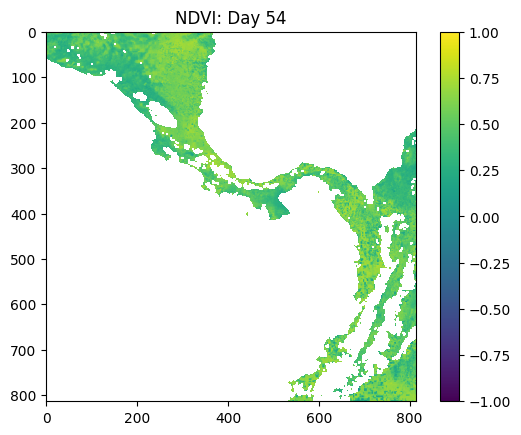

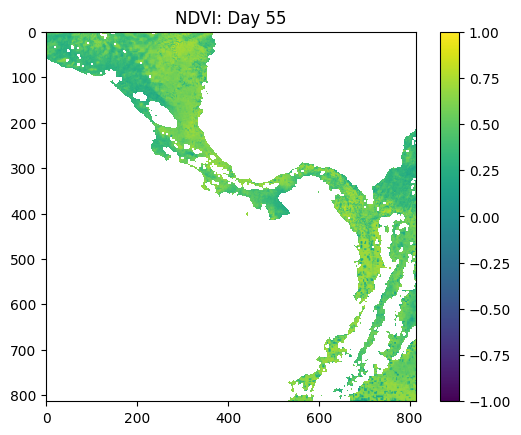

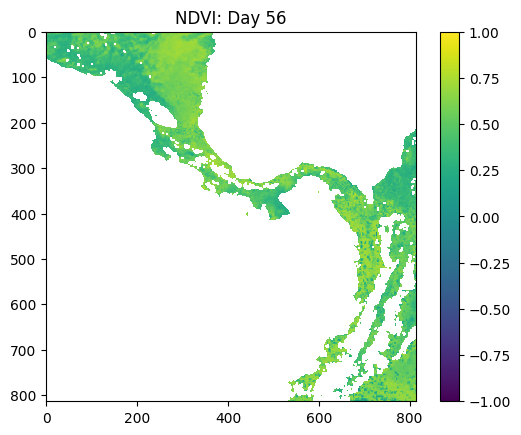

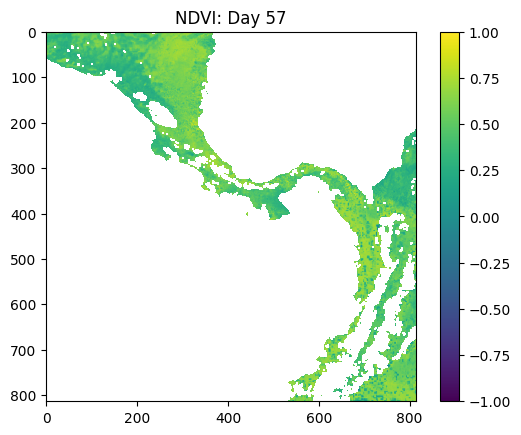

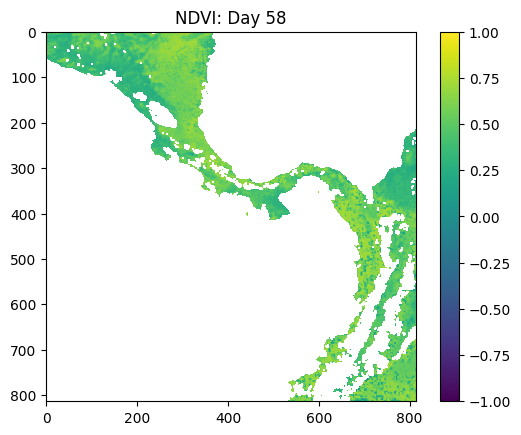

KeyboardInterrupt: ignored

In [ ]:
import numpy as np
import netCDF4 as nc
from google.cloud import storage
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def fetch_and_process_data(day):
    R = {}
    NIR = {}
    NDVI = {}
    sat = '16'
    product = 'ABI-L2-BRFF'
    year = '2022'
    hour = '18'
    storage_client = storage.Client.create_anonymous_client()

    day_str = str(day).zfill(3)

    bucket_name = f'gcp-public-data-goes-{sat}'
    prefix = f'{product}/{year}/{day}/{hour}'
    blob_list = list(storage_client.list_blobs(bucket_name, prefix=prefix))

    file = blob_list[0]
    file_name = file.name.replace("/", "_")
    out_file = f'/content/{file_name}'
    each_blob = storage.Blob(file.name, storage_client.get_bucket(bucket_name))
    ds = each_blob.download_to_filename(out_file)

    dataset = nc.Dataset(out_file)

    R_full = dataset.variables['BRF2'][:]
    NIR_full = dataset.variables['BRF3'][:]

    # Calculate the indices for slicing the arrays
    height, width = R_full.shape
    y_start, y_end = int(height * 0.35), int(height * 0.5) #0.3&0.55
    x_start, x_end = int(width * 0.35), int(width * 0.5)

    # Slice the arrays
    R[day_str] = R_full[y_start:y_end, x_start:x_end]
    NIR[day_str] = NIR_full[y_start:y_end, x_start:x_end]

    gamma = 1.5
    R[day_str] = np.power(R[day_str], 1/gamma)
    NIR[day_str] = np.power(NIR[day_str], 1/gamma)

    NDVI[day_str] = (NIR[day_str] - R[day_str]) / (R[day_str] + NIR[day_str])
    dataset.close()

    return NDVI[day_str]


def linear_sine(x, a, b, c, d, e):
    return a * x + b * np.sin(c * x + d) + e

start_day = 1
end_day = 365

# Days to skip
skip_days = [4, 64, 77, 139, 144, 241, 256, 321, 335]

# Initialize an empty dictionary to store NDVI data for each day
NDVI = {}
mean_ndvi = []

for day in range(start_day, end_day + 1):
    if day in skip_days:
        continue

    day_str = str(day).zfill(3)
    NDVI[day] = fetch_and_process_data(day_str)
    mean_ndvi.append(np.nanmean(NDVI[day]))

    # Plot the NDVI image
    plt.imshow(NDVI[day], cmap='viridis', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title(f"NDVI: Day {day}")
    plt.show()


In [ ]:
NDVI

{1: masked_array(
   data=[[0.3819041848182678, 0.35325151681900024, 0.32740768790245056,
          ..., --, --, --],
         [0.440233051776886, 0.39513394236564636, 0.38367635011672974,
          ..., --, --, --],
         [0.5239725708961487, 0.5059954524040222, 0.44010043144226074,
          ..., --, --, --],
         ...,
         [--, --, --, ..., 0.6673833131790161, 0.639716625213623,
          0.21698184311389923],
         [--, --, --, ..., 0.723963737487793, 0.4647529125213623,
          0.7556368112564087],
         [--, --, --, ..., 0.7485657334327698, 0.5493321418762207,
          0.5886192321777344]],
   mask=[[False, False, False, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False]],
   fill_value

Read ABI-L2-BRFF_2022_020_18_OR_ABI-L2-BRFF-M6_G16_s20220201800208_e20220201809516_c20220201811389.nc
Read ABI-L2-BRFF_2022_021_18_OR_ABI-L2-BRFF-M6_G16_s20220211800208_e20220211809516_c20220211811492.nc
Read ABI-L2-BRFF_2022_022_18_OR_ABI-L2-BRFF-M6_G16_s20220221800202_e20220221809510_c20220221811426.nc
Read ABI-L2-BRFF_2022_023_18_OR_ABI-L2-BRFF-M6_G16_s20220231800203_e20220231809511_c20220231811404.nc
Read ABI-L2-BRFF_2022_024_18_OR_ABI-L2-BRFF-M6_G16_s20220241800203_e20220241809511_c20220241811352.nc
Read ABI-L2-BRFF_2022_025_18_OR_ABI-L2-BRFF-M6_G16_s20220251800204_e20220251809511_c20220251811475.nc


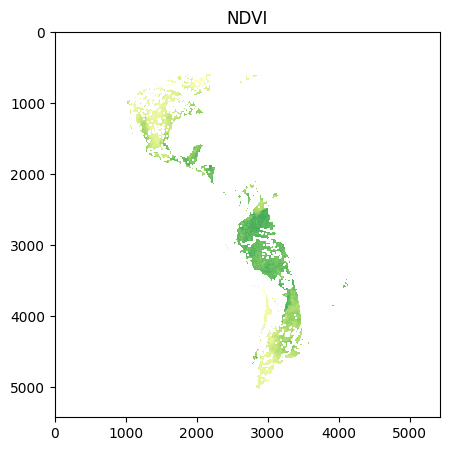

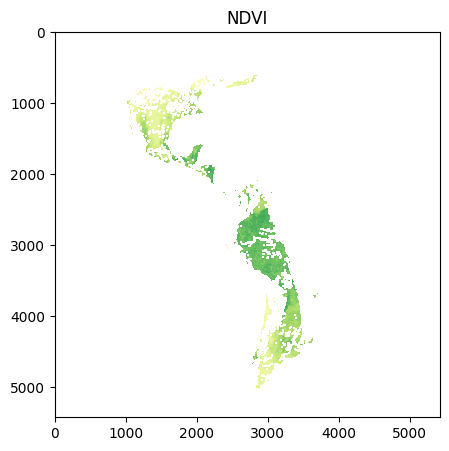

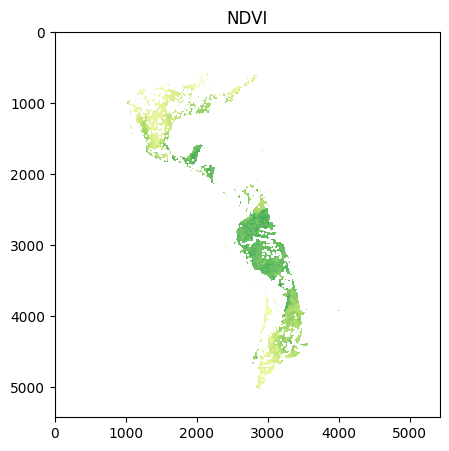

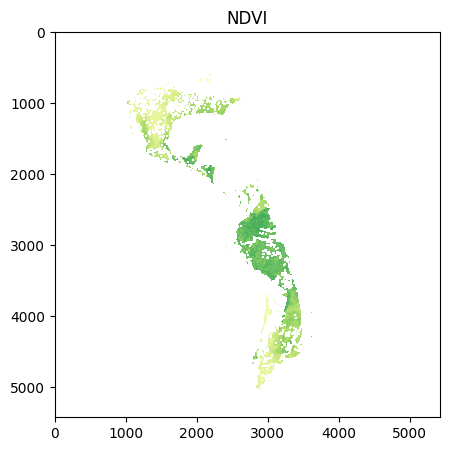

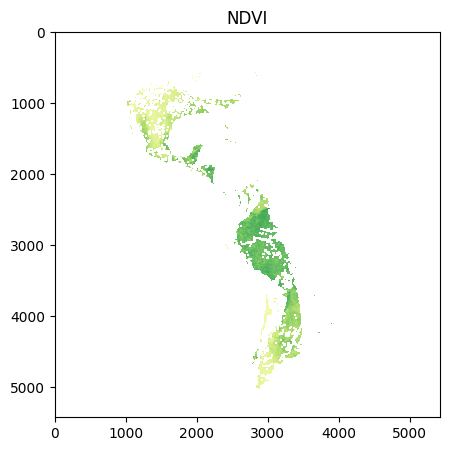

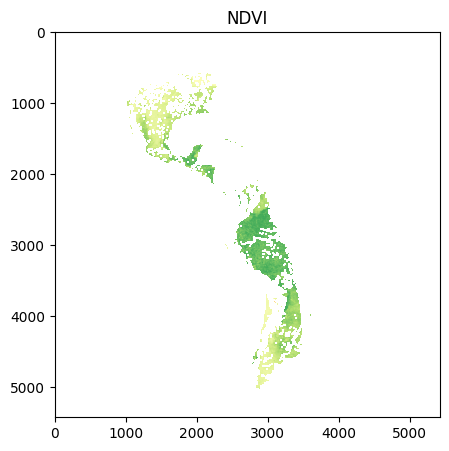

In [ ]:
import numpy as np
import netCDF4 as nc
from google.cloud import storage
import matplotlib.pyplot as plt

R = {}
B = {}
NIR = {}
NDVI = {}
sat = '16'
product = 'ABI-L2-BRFF'
year = '2022'
hour = '18'
storage_client = storage.Client.create_anonymous_client()

for day in range(20, 26):
    day_str = str(day).zfill(3)
    if day in [4, 64, 77, 139, 144, 241, 256, 321, 335]:
    # if day in [241, 256, 321, 335]:
      print('skipped', day)
      continue
      # missing data here

    bucket_name = 'gcp-public-data-goes-{sat}'.format(sat=sat)
    prefix = '{product}/{year}/{day}/{hour}'.format(product=product, year=year, day=day_str, hour=hour)
    bucket = storage_client.get_bucket(bucket_name)
    blob_list = list(storage_client.list_blobs(bucket_name, prefix=prefix))

    for file in blob_list:
        file_name = file.name.replace("/", "_")
        out_file = '/content/' + file_name
        each_blob = storage.Blob(file.name, bucket)
        ds = each_blob.download_to_filename(out_file)

        dataset = nc.Dataset(out_file)
        lat = (dataset.variables['y'][:])
        lon = (dataset.variables['x'][:])

        if day_str not in R:
            B[day_str] = np.zeros((len(lat), len(lon)))
            NIR[day_str] = np.zeros((len(lat), len(lon)))
            R[day_str] = np.zeros((len(lat), len(lon)))
            NDVI[day_str] = np.zeros((len(lat), len(lon)))
        BTEMP_DATA = dataset.variables['BRF1'][:]
        RTEMP_DATA = dataset.variables['BRF2'][:]
        NIRTEMP_DATA = dataset.variables['BRF3'][:]
        gamma = 1.5
        RTEMP_DATA = np.power(RTEMP_DATA, 1/gamma)
        NIRTEMP_DATA = np.power(NIRTEMP_DATA, 1/gamma)
        BTEMP_DATA = np.power(BTEMP_DATA, 1/gamma)
        B[day_str] = BTEMP_DATA
        R[day_str] = RTEMP_DATA
        NIR[day_str] = NIRTEMP_DATA
        NDVI[day_str] = (NIRTEMP_DATA - RTEMP_DATA)/(RTEMP_DATA + NIRTEMP_DATA)
        dataset.close()
        print('Read ' + file_name)

        # Break the loop after processing the first file
        break

# show the first day data
for day in range(20, 26):
  day_str = str(day).zfill(3)
  if day in [4, 64, 77, 139, 144, 241, 256, 321, 335]:
    # if day in [241, 256, 321, 335]:
    print('skipped', day)
    continue
    # missing data here
  fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
  ax.imshow(NDVI[f'{day_str}'], cmap='RdYlGn')
  ax.set_title('NDVI')
  plt.show()



Read ABI-L2-BRFF_2022_090_18_OR_ABI-L2-BRFF-M6_G17_s20220901800321_e20220901809388_c20220901810533.nc
Read ABI-L2-BRFF_2022_091_18_OR_ABI-L2-BRFF-M6_G17_s20220911800321_e20220911809388_c20220911811154.nc
Read ABI-L2-BRFF_2022_092_18_OR_ABI-L2-BRFF-M6_G17_s20220921800321_e20220921809388_c20220921811013.nc
Read ABI-L2-BRFF_2022_093_18_OR_ABI-L2-BRFF-M6_G17_s20220931800321_e20220931809388_c20220931811094.nc
Read ABI-L2-BRFF_2022_094_18_OR_ABI-L2-BRFF-M6_G17_s20220941800321_e20220941809387_c20220941810585.nc
Read ABI-L2-BRFF_2022_095_18_OR_ABI-L2-BRFF-M6_G17_s20220951800321_e20220951809388_c20220951811192.nc
Read ABI-L2-BRFF_2022_096_18_OR_ABI-L2-BRFF-M6_G17_s20220961800321_e20220961809388_c20220961810567.nc
Read ABI-L2-BRFF_2022_097_18_OR_ABI-L2-BRFF-M6_G17_s20220971800321_e20220971809388_c20220971811073.nc
Read ABI-L2-BRFF_2022_098_18_OR_ABI-L2-BRFF-M6_G17_s20220981800321_e20220981809388_c20220981811067.nc
Read ABI-L2-BRFF_2022_099_18_OR_ABI-L2-BRFF-M6_G17_s20220991800321_e20220991809388

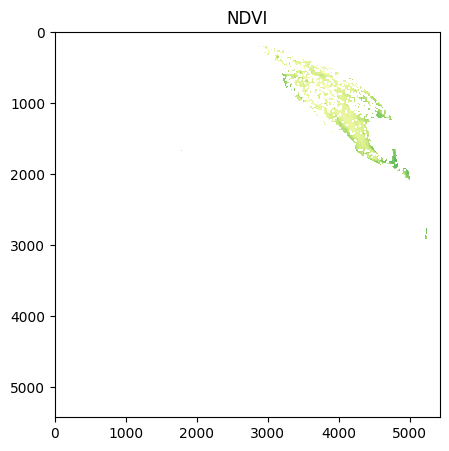

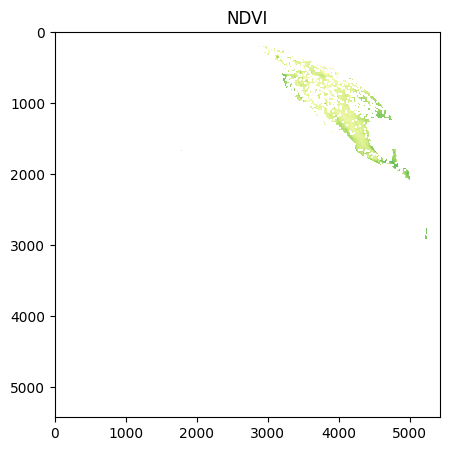

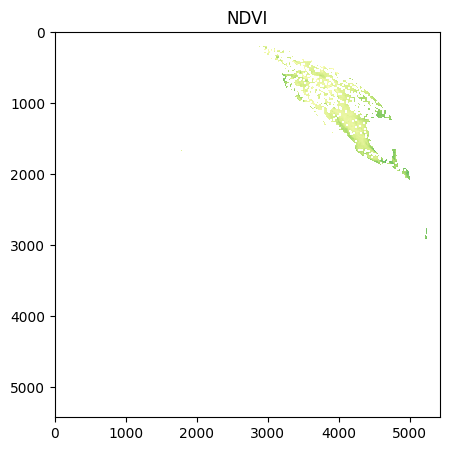

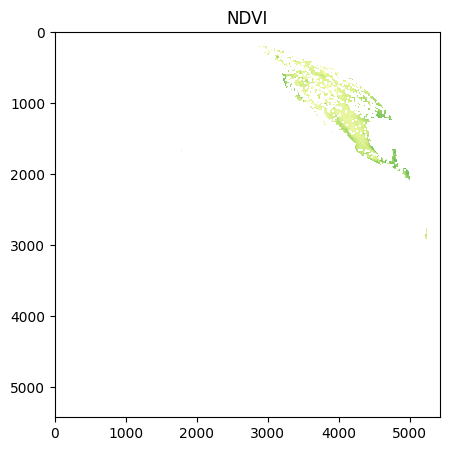

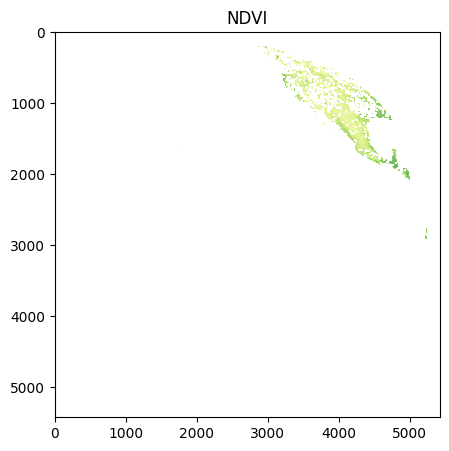

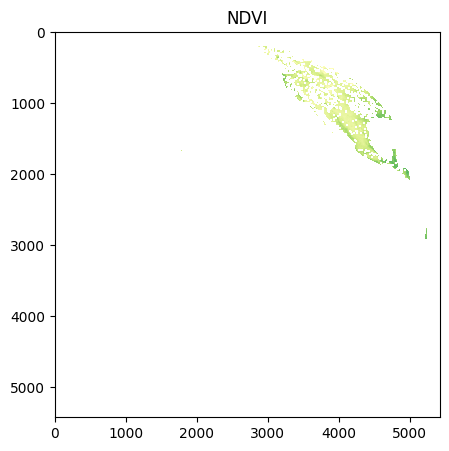

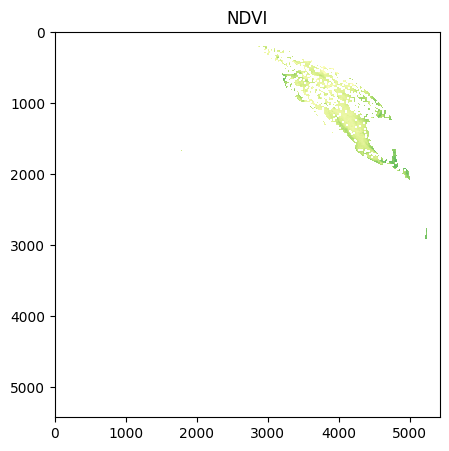

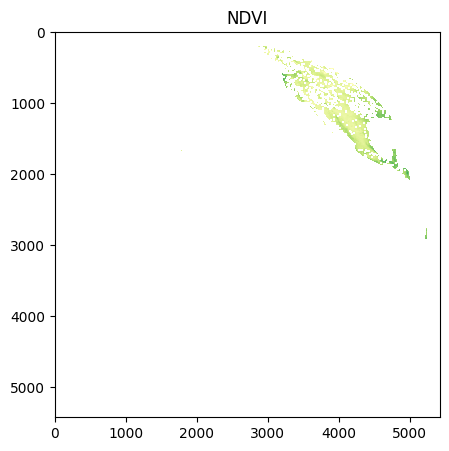

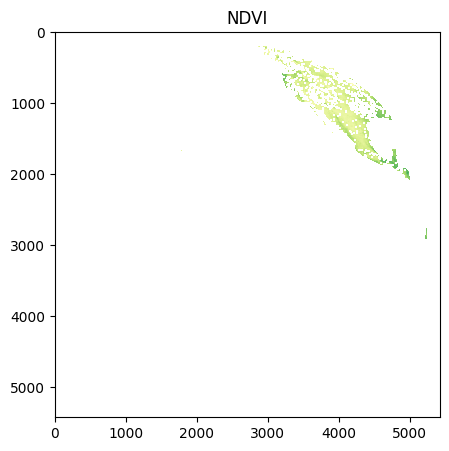

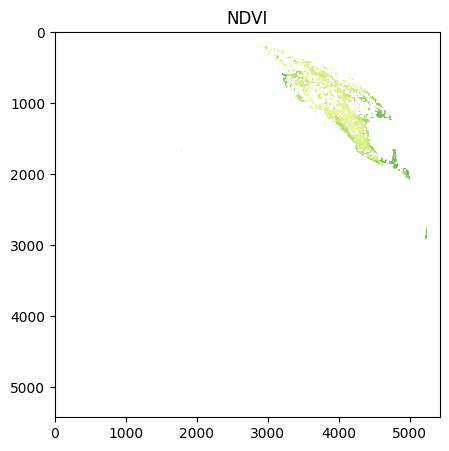

In [ ]:
import numpy as np
import netCDF4 as nc
from google.cloud import storage
import matplotlib.pyplot as plt

R = {}
B = {}
NIR = {}
NDVI = {}
sat = '16'
product = 'ABI-L2-BRFF'
year = '2022'
hour = '18'
storage_client = storage.Client.create_anonymous_client()

for day in range(90, 100):
    day_str = str(day).zfill(3)
    if day in [4, 64, 77, 139, 144, 241, 256, 321, 335]:
    # if day in [241, 256, 321, 335]:
      print('skipped', day)
      continue
      # missing data here

    bucket_name = 'gcp-public-data-goes-{sat}'.format(sat=sat)
    prefix = '{product}/{year}/{day}/{hour}'.format(product=product, year=year, day=day_str, hour=hour)
    bucket = storage_client.get_bucket(bucket_name)
    blob_list = list(storage_client.list_blobs(bucket_name, prefix=prefix))

    for file in blob_list:
        file_name = file.name.replace("/", "_")
        out_file = '/content/' + file_name
        each_blob = storage.Blob(file.name, bucket)
        ds = each_blob.download_to_filename(out_file)

        dataset = nc.Dataset(out_file)
        lat = (dataset.variables['y'][:])
        lon = (dataset.variables['x'][:])

        if day_str not in R:
            B[day_str] = np.zeros((len(lat), len(lon)))
            NIR[day_str] = np.zeros((len(lat), len(lon)))
            R[day_str] = np.zeros((len(lat), len(lon)))
            NDVI[day_str] = np.zeros((len(lat), len(lon)))
        BTEMP_DATA = dataset.variables['BRF1'][:]
        RTEMP_DATA = dataset.variables['BRF2'][:]
        NIRTEMP_DATA = dataset.variables['BRF3'][:]
        gamma = 1.5
        RTEMP_DATA = np.power(RTEMP_DATA, 1/gamma)
        NIRTEMP_DATA = np.power(NIRTEMP_DATA, 1/gamma)
        BTEMP_DATA = np.power(BTEMP_DATA, 1/gamma)
        B[day_str] = BTEMP_DATA
        R[day_str] = RTEMP_DATA
        NIR[day_str] = NIRTEMP_DATA
        NDVI[day_str] = (NIRTEMP_DATA - RTEMP_DATA)/(RTEMP_DATA + NIRTEMP_DATA)
        dataset.close()
        print('Read ' + file_name)

        # Break the loop after processing the first file
        break

# show the first day data
for day in range(90, 100):
  day_str = str(day).zfill(3)
  if day in [4, 64, 77, 139, 144, 241, 256, 321, 335]:
    # if day in [241, 256, 321, 335]:
    print('skipped', day)
    continue
    # missing data here
  fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
  ax.imshow(NDVI[f'{day_str}'], cmap='RdYlGn')
  ax.set_title('NDVI')
  plt.show()


In [ ]:
# Import Python packages

# Library to work with netCDF files
from netCDF4 import Dataset

# Library to perform array operations
import numpy as np

# Module to set filesystem paths appropriate for user's operating system
from pathlib import Path

In [ ]:
# Calculate latitude and longitude from GOES ABI fixed grid projection data
# GOES ABI fixed grid projection is a map projection relative to the GOES satellite
# Units: latitude in °N (°S < 0), longitude in °E (°W < 0)
# See GOES-R Product User Guide (PUG) Volume 5 (L2 products) Section 4.2.8 for details & example of calculations
# "file_id" is an ABI L1b or L2 .nc file opened using the netCDF4 library

def calculate_degrees(file_id):

    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = file_id.variables['x'][:]  # E/W scanning angle in radians
    y_coordinate_1d = file_id.variables['y'][:]  # N/S elevation angle in radians
    projection_info = file_id.variables['goes_imager_projection']
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height+projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis

    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)

    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)

    # Ignore numpy errors for sqrt of negative number; occurs for GOES-16 ABI CONUS sector data
    np.seterr(all='ignore')

    abi_lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    abi_lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)

    return abi_lat, abi_lon

In [ ]:
import numpy as np

directory_path = Path.cwd()  # Current working directory
file_name = 'ABI-L2-BRFF_2022_001_18_OR_ABI-L2-BRFF-M6_G16_s20220011800205_e20220011809513_c20220011811453.nc'
file_path = directory_path / file_name

# Open the file using the netCDF4 library
file_id = Dataset(file_path)

# Call function to calculate latitude and longitude from GOES ABI fixed grid projection data
abi_lat, abi_lon = calculate_degrees(file_id)

# Print max and min of latitude data to check data range
print('The maximum latitude value is', np.max(abi_lat), 'degrees')
print('The minimum latitude value is', np.min(abi_lat), 'degrees')

# Print max and min of longitude data to check data range
print('The maximum longitude value is', np.max(abi_lon), 'degrees')
print('The minimum longitude value is', np.min(abi_lon), 'degrees')


The maximum latitude value is 81.15669 degrees
The minimum latitude value is -81.15669 degrees
The maximum longitude value is 6.2708173 degrees
The minimum longitude value is -156.27083 degrees


In [ ]:
import numpy as np
import netCDF4 as nc
from google.cloud import storage
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def fetch_and_process_data(day):
    R = {}
    NIR = {}
    NDVI = {}
    sat = '16'
    product = 'ABI-L2-BRFF'
    year = '2022'
    hour = '18'
    storage_client = storage.Client.create_anonymous_client()

    day_str = str(day).zfill(3)

    bucket_name = f'gcp-public-data-goes-{sat}'
    prefix = f'{product}/{year}/{day}/{hour}'
    blob_list = list(storage_client.list_blobs(bucket_name, prefix=prefix))

    file = blob_list[0]
    file_name = file.name.replace("/", "_")
    out_file = f'/content/{file_name}'
    each_blob = storage.Blob(file.name, storage_client.get_bucket(bucket_name))
    ds = each_blob.download_to_filename(out_file)

    dataset = nc.Dataset(out_file)

    R_full = dataset.variables['BRF2'][:]
    NIR_full = dataset.variables['BRF3'][:]

    abi_lat, abi_lon = calculate_degrees(dataset)

    # Choose the Central America region
    lat_min, lat_max = 5, 25
    lon_min, lon_max = -100, -75

    mask = (abi_lat >= lat_min) & (abi_lat <= lat_max) & (abi_lon >= lon_min) & (abi_lon <= lon_max)

    R_full = np.where(mask, R_full, np.nan)
    NIR_full = np.where(mask, NIR_full, np.nan)

    gamma = 1.5
    R[day_str] = np.power(R_full, 1/gamma)
    NIR[day_str] = np.power(NIR_full, 1/gamma)

    NDVI[day_str] = (NIR[day_str] - R[day_str]) / (R[day_str] + NIR[day_str])
    dataset.close()
    # Add abi_lat and abi_lon to the return statement
    return NDVI[day_str], abi_lat, abi_lon

start_day = 1
end_day = 5

# Days to skip
skip_days = [4, 64, 77, 139, 144, 241, 256, 321, 335]

# Initialize an empty dictionary to store NDVI data for each day
NDVI = {}

for day in range(start_day, end_day + 1):
    if day in skip_days:
        continue

    day_str = str(day).zfill(3)

    NDVI[day], lat, lon = fetch_and_process_data(day_str)
    # Plot the NDVI image
    fig, ax = plt.subplots()
    c = ax.pcolormesh(lon, lat, NDVI[day], cmap='viridis', vmin=-1, vmax=1)
    fig.colorbar(c, ax=ax)
    ax.set_title(f"NDVI: Day {day}")

    # Set the axis limits to focus on the study area
    ax.set_xlim(-100, -75)
    ax.set_ylim(5, 25)

    plt.show()


# Stack the NDVI arrays for each day
ndvi_stack = np.stack([NDVI[day] for day in NDVI.keys()])

# Calculate the mean NDVI for each pixel
ndvi_mean = np.nanmean(ndvi_stack, axis=0)

# Visualize the mean NDVI for Central America in 2022
plt.imshow(ndvi_mean, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar()
plt.title("Mean NDVI for Central America in 2022")
plt.show()


ModuleNotFoundError: ignored

In [ ]:
import numpy as np
import netCDF4 as nc
from google.cloud import storage
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def calculate_degrees(file_id):

    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = file_id.variables['x'][:]  # E/W scanning angle in radians
    y_coordinate_1d = file_id.variables['y'][:]  # N/S elevation angle in radians
    projection_info = file_id.variables['goes_imager_projection']
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height+projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis

    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)

    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)

    # Ignore numpy errors for sqrt of negative number; occurs for GOES-16 ABI CONUS sector data
    np.seterr(all='ignore')

    abi_lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    abi_lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)

    return abi_lat, abi_lon

def fetch_and_process_data(day):
    R = {}
    NIR = {}
    NDVI = {}
    sat = '16'
    product = 'ABI-L2-BRFF'
    year = '2022'
    hour = '18'
    storage_client = storage.Client.create_anonymous_client()

    day_str = str(day).zfill(3)

    bucket_name = f'gcp-public-data-goes-{sat}'
    prefix = f'{product}/{year}/{day}/{hour}'
    blob_list = list(storage_client.list_blobs(bucket_name, prefix=prefix))

    file = blob_list[0]
    file_name = file.name.replace("/", "_")
    out_file = f'/content/{file_name}'
    each_blob = storage.Blob(file.name, storage_client.get_bucket(bucket_name))
    ds = each_blob.download_to_filename(out_file)

    dataset = nc.Dataset(out_file)


    R_full = dataset.variables['BRF2'][:]
    NIR_full = dataset.variables['BRF3'][:]

    abi_lat, abi_lon = calculate_degrees(dataset)

    # Choose the Central America region
    lat_min, lat_max = 5, 25
    lon_min, lon_max = -100, -75

    mask = (abi_lat >= lat_min) & (abi_lat <= lat_max) & (abi_lon >= lon_min) & (abi_lon <= lon_max)

    R_full = np.where(mask, R_full, np.nan)
    NIR_full = np.where(mask, NIR_full, np.nan)

    gamma = 1.5
    R[day_str] = np.power(R_full, 1/gamma)
    NIR[day_str] = np.power(NIR_full, 1/gamma)

    NDVI[day_str] = (NIR[day_str] - R[day_str]) / (R[day_str] + NIR[day_str])
    dataset.close()
    # Add abi_lat and abi_lon to the return statement
    return NDVI[day_str], abi_lat, abi_lon


start_day = 1
end_day = 5

# Days to skip
skip_days = [4, 64, 77, 139, 144, 241, 256, 321, 335]

# Initialize an empty dictionary to store NDVI data for each day
NDVI = {}

import numpy as np
import netCDF4 as nc
from google.cloud import storage
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def calculate_degrees(file_id):

    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = file_id.variables['x'][:]  # E/W scanning angle in radians
    y_coordinate_1d = file_id.variables['y'][:]  # N/S elevation angle in radians
    projection_info = file_id.variables['goes_imager_projection']
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height+projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis

    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)

    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)

    # Ignore numpy errors for sqrt of negative number; occurs for GOES-16 ABI CONUS sector data
    np.seterr(all='ignore')

    abi_lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    abi_lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)

    return abi_lat, abi_lon

def fetch_and_process_data(day):
    R = {}
    NIR = {}
    NDVI = {}
    sat = '16'
    product = 'ABI-L2-BRFF'
    year = '2022'
    hour = '18'
    storage_client = storage.Client.create_anonymous_client()

    day_str = str(day).zfill(3)

    bucket_name = f'gcp-public-data-goes-{sat}'
    prefix = f'{product}/{year}/{day}/{hour}'
    blob_list = list(storage_client.list_blobs(bucket_name, prefix=prefix))

    file = blob_list[0]
    file_name = file.name.replace("/", "_")
    out_file = f'/content/{file_name}'
    each_blob = storage.Blob(file.name, storage_client.get_bucket(bucket_name))
    ds = each_blob.download_to_filename(out_file)

    dataset = nc.Dataset(out_file)


    R_full = dataset.variables['BRF2'][:]
    NIR_full = dataset.variables['BRF3'][:]

    abi_lat, abi_lon = calculate_degrees(dataset)

    # Choose the Central America region
    lat_min, lat_max = 5, 25
    lon_min, lon_max = -100, -75

    mask = (abi_lat >= lat_min) & (abi_lat <= lat_max) & (abi_lon >= lon_min) & (abi_lon <= lon_max)

    R_full = np.where(mask, R_full, np.nan)
    NIR_full = np.where(mask, NIR_full, np.nan)

    gamma = 1.5
    R[day_str] = np.power(R_full, 1/gamma)
    NIR[day_str] = np.power(NIR_full, 1/gamma)

    NDVI[day_str] = (NIR[day_str] - R[day_str]) / (R[day_str] + NIR[day_str])
    dataset.close()
    # Add abi_lat and abi_lon to the return statement
    return NDVI[day_str], abi_lat, abi_lon


start_day = 1
end_day = 5

# Days to skip
skip_days = [4, 64, 77, 139, 144, 241, 256, 321, 335]

# Initialize an empty dictionary to store NDVI data for each day
NDVI = {}

for day in range(start_day, end_day + 1):
    if day in skip_days:
        continue

    day_str = str(day).zfill(3)
    NDVI[day] = fetch_and_process_data(day_str)

    # Mask the abi_lat and abi_lon arrays to keep only the Central America region
    masked_abi_lat = np.where(mask, abi_lat, np.nan)
    masked_abi_lon = np.where(mask, abi_lon, np.nan)

    # Plot the NDVI image using latitude and longitude coordinates
    fig, ax = plt.subplots()
    cmap = plt.get_cmap('viridis')
    norm = colors.Normalize(vmin=-1, vmax=1)
    cax = ax.pcolormesh(masked_abi_lon, masked_abi_lat, NDVI[day], cmap=cmap, norm=norm)
    fig.colorbar(cax, ax=ax, label="NDVI")
    ax.set_title(f"NDVI: Day {day}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()


ModuleNotFoundError: ignored